In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nn_backend.import_xyz_img import import_xyz_img
from sklearn.preprocessing import StandardScaler
from nn_backend.conv_imgs import conv_imgs
from nn_backend.data_import import matrix_cut, mask_from_topo
from sklearn.model_selection import ShuffleSplit

import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, concatenate
from keras.optimizers import Adam
from keras.utils import set_random_seed


In [2]:

topography_file=rf'c:\Users\mcano\Code\rawdata\img_data\EFM9\TopographyEFM9_nm.txt'
binary_threshold=0.04 #Threshold for the topography image flood
object_size=3 #Maximum object size that should be eliminated as noise
hole_size=30 #Maximum hole size that should be filled in the mask
m_ep_thresh=0.30 #Threshold for the simulation image flood
cutout_size=9 #Size of the topography cutouts for the convolution operation
kernel_dim=3 #Kernel dimension for the convolution operation
summary=0
pctg=90
iterations=10
batch_sz=200 #Batch size for training


In [3]:

T_mat, ax_ep, ay_ep= import_xyz_img(topography_file)
og_dim=len(T_mat) #Dimensions of the final εp map
T=pd.DataFrame(np.reshape(T_mat,og_dim**2))
topo_scale=StandardScaler()
topo_scale.fit(T)
Tn=topo_scale.transform(T)
Tn_mat=Tn.reshape(len(T_mat),len(T_mat),1)

Cv_mat=conv_imgs(Tn_mat[:,:,0], cutout_size)
Cv_mat=np.expand_dims(Cv_mat, axis=-1)
nu_dim=len(Tn_mat)-cutout_size+1
Tn_mat=matrix_cut(Tn_mat,len(Tn_mat)-cutout_size+1)
Tn=pd.DataFrame(Tn_mat.reshape(len(Tn_mat)*len(Tn_mat),1))
T_mat=matrix_cut(T_mat,len(T_mat)-cutout_size+1)
T=T_mat.reshape(len(T_mat)*len(T_mat),1)

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [00:23<00:00,  5.01it/s]


In [4]:
bin=mask_from_topo(T,binary_threshold,object_size,hole_size)
y=pd.DataFrame(bin.reshape(nu_dim**2))


In [5]:
sss = ShuffleSplit(n_splits=1, test_size=1-(pctg/100), random_state=1)
sss.get_n_splits(Tn, y)
train_index, test_index = next(sss.split(Tn, y))
train_index=np.sort(train_index)  
test_index=np.sort(test_index)  



X_train, X_test = Tn.iloc[train_index], Tn.iloc[test_index] 
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Cv_train, Cv_test = Cv_mat[train_index,:,:], Cv_mat[test_index,:,:] 

In [6]:
set_random_seed(1)
inp_x=Input(shape=(len(Tn.columns),))
inp_cv=Input(shape=(np.shape(Cv_mat[0])))


cv=Conv2D(filters=32, kernel_size=(kernel_dim, kernel_dim), activation='relu')(inp_cv)
cv=Flatten()(cv)
cv=Dense(256,activation ="relu")(cv)
cv=Model(inputs=inp_cv, outputs=cv)

x=Dense(4, activation='relu')(inp_x)
x=Model(inputs=inp_x, outputs=x)

mix=concatenate([x.output,cv.output])

mix=Dense(32, activation='relu')(mix)
mix=Dense(8, activation='relu')(mix)
out=Dense(1, activation='sigmoid')(mix)

reg = Model(inputs=[x.input, cv.input], outputs=out)
if summary:
    reg.summary()
reg.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])
histo=reg.fit([X_train,Cv_train], y_train, batch_size=batch_sz, epochs=iterations, validation_data=[[X_test,Cv_test],y_test], verbose=1)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8280 - loss: 0.3473 - val_accuracy: 0.9646 - val_loss: 0.0931
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9731 - loss: 0.0774 - val_accuracy: 0.9722 - val_loss: 0.0734
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9820 - loss: 0.0508 - val_accuracy: 0.9806 - val_loss: 0.0486
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9866 - loss: 0.0372 - val_accuracy: 0.9882 - val_loss: 0.0315
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9897 - loss: 0.0316 - val_accuracy: 0.9882 - val_loss: 0.0285
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9913 - loss: 0.0277 - val_accuracy: 0.9896 - val_loss: 0.0254
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9928 - loss: 0.0237 - val_accuracy: 0.9903 - val_loss: 0.0243
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9934 - loss: 0.0209 - val_accuracy: 0.9896 - val_loss

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


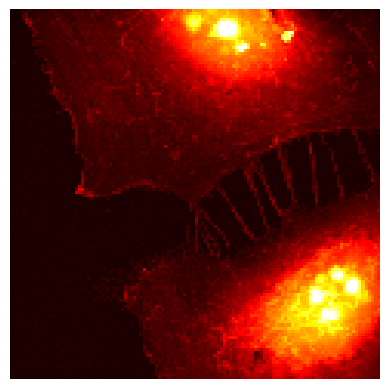

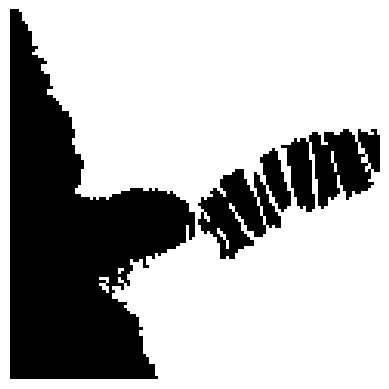

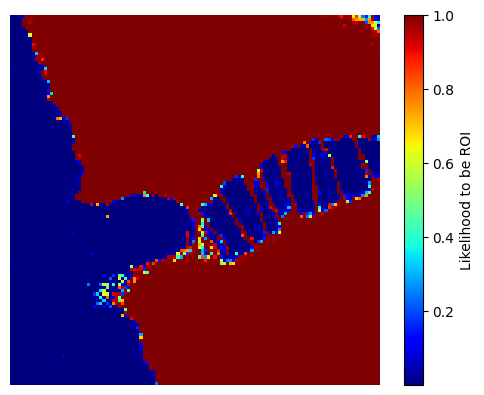

In [13]:
res=reg.predict([Tn, Cv_mat])
plt.imshow(T_mat.reshape(nu_dim, nu_dim), cmap='hot')
plt.axis('off')
plt.figure()
plt.imshow(bin.reshape(nu_dim, nu_dim), cmap='grey')
plt.axis('off')
plt.figure()
plt.imshow(res.reshape(nu_dim, nu_dim), cmap='jet')
plt.axis('off')
plt.colorbar(label="Likelihood to be ROI")

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [00:24<00:00,  4.96it/s]

  1/450 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


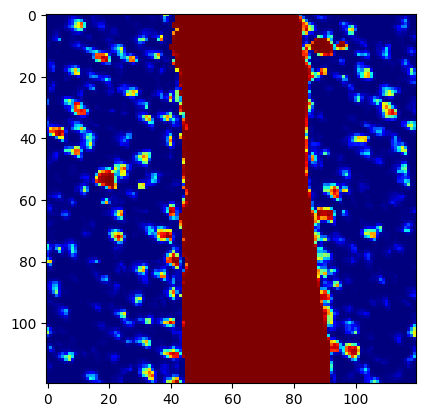

In [48]:
topography_file=rf'c:\Users\mcano\Code\rawdata\img_data\EFM8\Topography Flattened EFM8.txt'
T_mat, ax_ep, ay_ep= import_xyz_img(topography_file)
og_dim=len(T_mat) #Dimensions of the final εp map
T=pd.DataFrame(np.reshape(T_mat,og_dim**2))
topo_scale=StandardScaler()
topo_scale.fit(T)
Tn=topo_scale.transform(T)
Tn_mat=Tn.reshape(len(T_mat),len(T_mat),1)

Cv_mat=conv_imgs(Tn_mat[:,:,0], cutout_size)
Cv_mat=np.expand_dims(Cv_mat, axis=-1)
nu_dim=len(Tn_mat)-cutout_size+1
Tn_mat=matrix_cut(Tn_mat,len(Tn_mat)-cutout_size+1)
Tn=pd.DataFrame(Tn_mat.reshape(len(Tn_mat)*len(Tn_mat),1))
res=reg.predict([Tn, Cv_mat])
plt.imshow(res.reshape(nu_dim, nu_dim), cmap='jet')